### Examples of how to use btk to asses detection algorithm performance 
This tutorial shows how to btk can produce metrics to asses the performance of a detection algorithm. Detected centroids are compared to true centers to ascertain if a source was detected or not. First, the on plane euclidean distance, d, between a true source and deteceted object is computed. If d is less tah a certain criterion then we match a detected object to a true source. This source matching is done in two ways. 
1. if d < 5 pixels, then detection is matched to the source.
2. if d/size < 0.5 where size is the PSF convolved sigma of the true source

Detection metrics are computed for:
1. SEP (Source Extractor in Python)
2. DM Stack (LSST Science Pipeline)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
import btk.config, btk.plot_utils

Define a function that returns a `btk.measure generator` when input a class `meas_params`. `meas_params` contains functions that perform the detection. Defining this function here saves us the task of creating a new btk.draw_blends generator for each new detection algorithm we want to test, while also making sure we get the same dataset.

Note: This function uses the One square Degree CatSim catalog as input. For more details on
the input catalog refer [here](https://blendingtoolkit.readthedocs.io/en/latest/catalog.html).

In [2]:
def get_meas_generator(meas_params):
    """Returns generator that yields output of user defined algorithm specified in meas_param.    
    Measurements are performed for default sampling function with maximum of 6 objects per blend.
    
    Returns:
        meas_generator: Generator that yeilds output of deblender and measurement algorithm..
    """
    # Load parameters
    #Input catalog name
    catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
    param = btk.config.Simulation_params(catalog_name,batch_size=4, max_number=6 )
    np.random.seed(param.seed)

    #Load input catalog
    catalog = btk.get_input_catalog.load_catalog(param)

    #Generate catlogs of blended objects 
    blend_generator = btk.create_blend_generator.generate(param, catalog)

    #Generates observing conditions for the selected survey_name and all input bands
    observing_generator = btk.create_observing_generator.generate(param)
    
    np.random.seed(int(param.seed))
    #Generate images of blends in all the observing bands
    draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 
    # get generator that yields measured values.
    meas_generator = btk.measure.generate(
            meas_params, draw_blend_generator, param)
    return meas_generator, param



## Finding peak with SEP (Source extractor in python)

Note: This requires sep to have been installed

We first show results of the detection method and the two matching algorithm for four difffernt blend images.


In [3]:
meas_param = btk.utils.SEP_params()
meas_generator, param = get_meas_generator(meas_param)
metric_param = btk.utils.Basic_metric_params(meas_generator=meas_generator, sim_param=param)
results = btk.compute_metrics.run(metric_param, test_size=1)
true_p, detected_p, blend_list_p = results['detection']

Using matching algorithm1
Out of 5 true sources 4 were detected, 1 were undetected, with 0 being shredded,
Out of 4 detections, 4 were matched, 0 were spurious
Using matching algorithm2
Out of 5 true sources 4 were detected, 1 were undetected, with 0 being shredded,
Out of 4 detections, 4 were matched, 0 were spurious


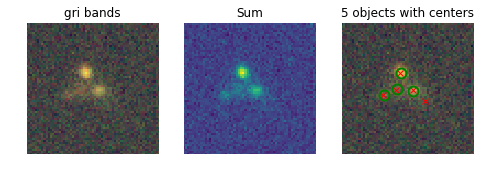

Using matching algorithm1
Out of 2 true sources 1 were detected, 1 were undetected, with 0 being shredded,
Out of 1 detections, 1 were matched, 0 were spurious
Using matching algorithm2
Out of 2 true sources 1 were detected, 1 were undetected, with 0 being shredded,
Out of 1 detections, 1 were matched, 0 were spurious


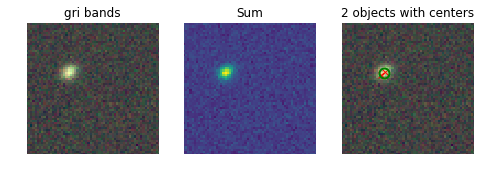

Using matching algorithm1
Out of 1 true sources 1 were detected, 0 were undetected, with 0 being shredded,
Out of 1 detections, 1 were matched, 0 were spurious
Using matching algorithm2
Out of 1 true sources 1 were detected, 0 were undetected, with 0 being shredded,
Out of 1 detections, 1 were matched, 0 were spurious


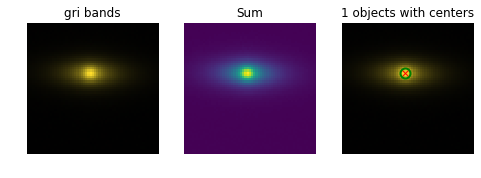

Using matching algorithm1
Out of 6 true sources 3 were detected, 3 were undetected, with 0 being shredded,
Out of 3 detections, 3 were matched, 0 were spurious
Using matching algorithm2
Out of 6 true sources 3 were detected, 3 were undetected, with 0 being shredded,
Out of 3 detections, 3 were matched, 0 were spurious


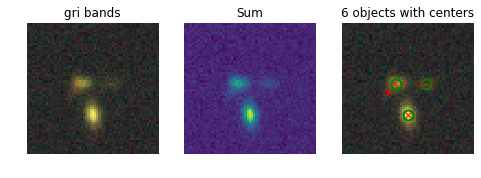

In [4]:
meas_params = btk.utils.Basic_measure_params()
meas_generator, param = get_meas_generator(meas_param)
output, deb, _ = next(meas_generator)
blend_list = output['blend_list']
figs = []
count = 0
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    blend_detected = detected_p[detected_p['blend_index']==i]
    print("Using matching algorithm1")
    print(f"Out of {blend_list_p[i][0]} true sources {blend_list_p[i][1]} were detected, "
          f"{blend_list_p[i][2]} were undetected, with {blend_list_p[i][4]} being shredded,")
    print(f"Out of {len(blend_detected)} detections, "
          f"{len(blend_detected[blend_detected['match_true_id1']!=-1])} were matched, {blend_list_p[i][3]} were spurious")
    print("Using matching algorithm2")
    print(f"Out of {blend_list_p[i][0]} true sources {blend_list_p[i][5]} were detected, "
          f"{blend_list_p[i][6]} were undetected, with {blend_list_p[i][8]} being shredded,")
    print(f"Out of {len(blend_detected)} detections, "
          f"{len(blend_detected[blend_detected['match_true_id2']!=-1])} were matched, {blend_list_p[i][7]} were spurious")
    btk.plot_utils.plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

To numerically quantify the performance of a detection algorithm, we run `btk.compute_metrics` with a test size of 100 batches (100$\times$4 blends).
We then count the number of sources that were correctly detcted as a function of magnitude, size and distance to nearest neighbor. These cumulative plots are a function of the true parametrs of the source galaxies.

We then make a summary matrix that shows the number of detections as a function of the number of sources in the blend. The detection here include spurious predictions.
We make a similar plot again, but this time with only the correctly matched detections.

In [5]:
meas_param = btk.utils.SEP_params()
meas_generator, param = get_meas_generator(meas_param)
metric_param = btk.utils.Basic_metric_params(meas_generator=meas_generator, sim_param=param)
results = btk.compute_metrics.run(metric_param, test_size=100)
true_table, detected_table, detection_summary = results['detection']

match1 precision:  0.99875 recall:  0.5694939415538133
match2 precision:  0.9925 recall:  0.5659301496792587


Text(0, 0.5, '# detected objects')

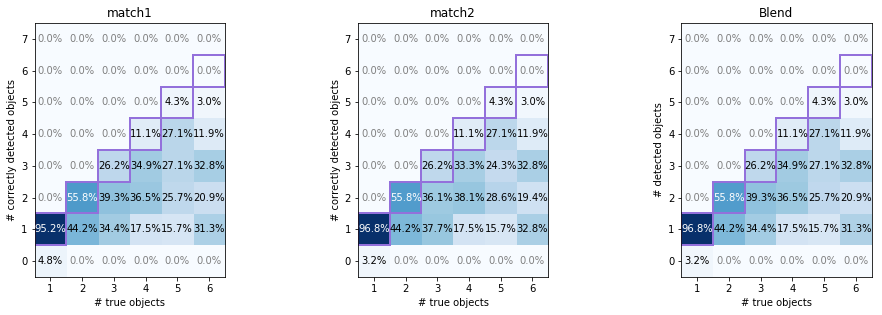

In [6]:
num = np.array(detection_summary).max()

_, ax = plt.subplots(1,3,figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#match1
det_summary = np.array(detection_summary)
tot = np.sum(det_summary[:, 0])
det = np.sum(det_summary[:, 1])
spur = np.sum(det_summary[:, 3])
print("match1", "precision: ", float(det/(det + spur)), "recall: ", float(det/(tot)))
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[0])
ax[0].set_title('match1')
    
# match 2
summ = np.array(detection_summary)
det_summary = np.concatenate([summ[:, 0, np.newaxis], summ[:, 5:]], axis=1)
tot = np.sum(det_summary[:, 0])
det = np.sum(det_summary[:, 1])
spur = np.sum(det_summary[:, 3])

print("match2", "precision: ", float(det/(det + spur)), "recall: ", float(det/(tot)))
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[1])
ax[1].set_title('match2')

summ = np.array(detection_summary)
det_summary = np.concatenate([summ[:, 0, np.newaxis], summ[:, 5:]], axis=1)
det_summary[:, 1] += det_summary[:, 3] +det_summary[:, 4]
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[2])
ax[2].set_title('Blend')
ax[2].set_ylabel('# detected objects')

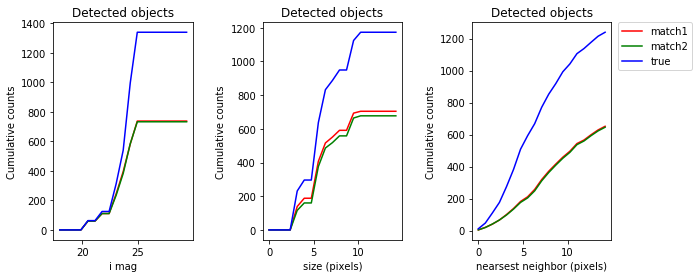

In [7]:
_, axs = plt.subplots(1,3,figsize=(10,4))
plt.subplots_adjust(wspace=0.5, hspace=0.)
mag_bins = np.linspace(18, 30, 20)
size_bins = np.linspace(0, 15, 20)
dist_bins = np.linspace(0, 15, 20)
# match1
true_table['min_dist'][np.isinf(true_table['min_dist'])] =128
q_detected, = np.where(true_table['num_detections1'] ==1)
# Plot by magnitude    
btk.plot_utils.plot_cumulative(true_table[q_detected], 'i_ab', axs[0],
                           mag_bins, color='r', xlabel='i mag', label='match1')
# Plot by size
btk.plot_utils.plot_cumulative(true_table[q_detected], 'size', axs[1],
                           size_bins, color='r', xlabel='size (pixels)', label='match1')
# Plot by min dist to neighbor 
btk.plot_utils.plot_cumulative(true_table[q_detected], 'min_dist', axs[2],
                           dist_bins, color='r', xlabel='nearsest neighbor (pixels)', label='match1')
# match2
true_table['min_dist'][np.isinf(true_table['min_dist'])] = 128
q_detected, = np.where(true_table['num_detections2'] ==1)
# Plot by magnitude    
btk.plot_utils.plot_cumulative(true_table[q_detected], 'i_ab', axs[0],
                           mag_bins, color='g', xlabel='i mag', label='match2')
# Plot by size
btk.plot_utils.plot_cumulative(true_table[q_detected], 'size', axs[1],
                           size_bins, color='g', xlabel='size (pixels)', label='match2')
# Plot by min dist to neighbor 
btk.plot_utils.plot_cumulative(true_table[q_detected], 'min_dist', axs[2],
                           dist_bins, color='g', xlabel='nearsest neighbor (pixels)', label='match2')
#true entries
# Plot by magnitude    
btk.plot_utils.plot_cumulative(true_table, 'i_ab', axs[0],
                           mag_bins, color='blue', xlabel='i mag', label='true')
# Plot by size
btk.plot_utils.plot_cumulative(true_table, 'size', axs[1],
                           size_bins, color='blue', xlabel='size (pixels)', label='true')
# Plot by min dist to neighbor 
btk.plot_utils.plot_cumulative(true_table, 'min_dist', axs[2],
                           dist_bins, color='blue', xlabel='nearsest neighbor (pixels)', label='true')
axs[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].set_title("Detected objects")
axs[1].set_title("Detected objects")
axs[2].set_title("Detected objects")
plt.show()



## Detectection metrics for LSST Science Pipeline (stack)


In [5]:
import astropy.table
class Stack_metric_params(btk.compute_metrics.Metrics_params):
    def __init__(self, *args, **kwargs):
        super(Stack_metric_params, self).__init__(*args, **kwargs)
        """Class describing functions to return results of
         detection/deblending/measurement algorithm in meas_generator. Each
         blend results yielded by the meas_generator for a batch.
    """

    def get_detections(self):
        """Returns blend catalog and detection catalog for detction performed

        Returns:
            Results of the detection algorithm are returned as:
                true_tables:  List of astropy Tables of the blend catalogs of the
                    batch. Length of tables must be the batch size. x and y coordinate
                    values must be under columns named 'dx' and 'dy' respectively, in
                    pixels from bottom left corner as (0, 0).
                detected_tables: List of astropy Tables of output from detection
                    algorithm. Length of tables must be the batch size. x and y
                    coordinate values must be under columns named 'dx' and 'dy'
                    respectively, in pixels from bottom left corner as (0, 0).
        """
        # Astropy table with entries corresponding to true sources
        blend_op, _, cat = next(self.meas_generator)
        true_tables = blend_op['blend_list']
        detected_tables = []
        for i in range(len(true_tables)):
            detected_centers = np.stack([cat[i]['base_NaiveCentroid_x'], cat[i]['base_NaiveCentroid_y']], axis=1)
            detected_table = astropy.table.Table(detected_centers,
                                                 names=['dx', 'dy'])
            detected_tables.append(detected_table)
        return true_tables, detected_tables

In [6]:
meas_param = btk.utils.Stack_params()
meas_generator, param = get_meas_generator(meas_param)
metric_param = Stack_metric_params(meas_generator=meas_generator, sim_param=param)
results = btk.compute_metrics.run(metric_param, test_size=100)
true_table, detected_table, detection_summary = results['detection']


match1 precision:  0.996309963099631 recall:  0.5773342836778332
match2 precision:  0.9925558312655087 recall:  0.5702066999287242


Text(0, 0.5, '# detected objects')

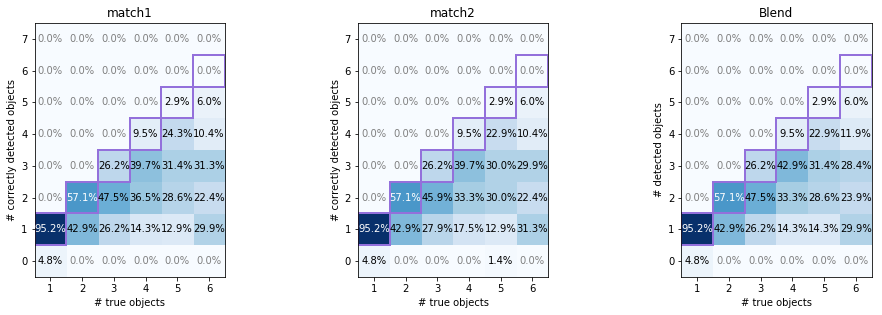

In [7]:
num = np.array(detection_summary).max()

_, ax = plt.subplots(1,3,figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#match1
det_summary = np.array(detection_summary)
tot = np.sum(det_summary[:, 0])
det = np.sum(det_summary[:, 1])
spur = np.sum(det_summary[:, 3])
print("match1", "precision: ", float(det/(det + spur)), "recall: ", float(det/(tot)))
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[0])
ax[0].set_title('match1')
    
# match 2
summ = np.array(detection_summary)
det_summary = np.concatenate([summ[:, 0, np.newaxis], summ[:, 5:]], axis=1)
tot = np.sum(det_summary[:, 0])
det = np.sum(det_summary[:, 1])
spur = np.sum(det_summary[:, 3])

print("match2", "precision: ", float(det/(det + spur)), "recall: ", float(det/(tot)))
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[1])
ax[1].set_title('match2')

summ = np.array(detection_summary)
det_summary = np.concatenate([summ[:, 0, np.newaxis], summ[:, 5:]], axis=1)
det_summary[:, 1] += det_summary[:, 3] +det_summary[:, 4]
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[2])
ax[2].set_title('Blend')
ax[2].set_ylabel('# detected objects')

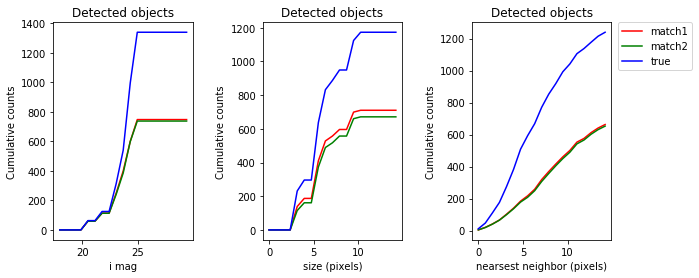

In [8]:
_, axs = plt.subplots(1,3,figsize=(10,4))
plt.subplots_adjust(wspace=0.5, hspace=0.)
mag_bins = np.linspace(18, 30, 20)
size_bins = np.linspace(0, 15, 20)
dist_bins = np.linspace(0, 15, 20)
# match1
true_table['min_dist'][np.isinf(true_table['min_dist'])] =128
q_detected, = np.where(true_table['num_detections1'] ==1)
# Plot by magnitude    
btk.plot_utils.plot_cumulative(true_table[q_detected], 'i_ab', axs[0],
                           mag_bins, color='r', xlabel='i mag', label='match1')
# Plot by size
btk.plot_utils.plot_cumulative(true_table[q_detected], 'size', axs[1],
                           size_bins, color='r', xlabel='size (pixels)', label='match1')
# Plot by min dist to neighbor 
btk.plot_utils.plot_cumulative(true_table[q_detected], 'min_dist', axs[2],
                           dist_bins, color='r', xlabel='nearsest neighbor (pixels)', label='match1')
# match2
true_table['min_dist'][np.isinf(true_table['min_dist'])] = 128
q_detected, = np.where(true_table['num_detections2'] ==1)
# Plot by magnitude    
btk.plot_utils.plot_cumulative(true_table[q_detected], 'i_ab', axs[0],
                           mag_bins, color='g', xlabel='i mag', label='match2')
# Plot by size
btk.plot_utils.plot_cumulative(true_table[q_detected], 'size', axs[1],
                           size_bins, color='g', xlabel='size (pixels)', label='match2')
# Plot by min dist to neighbor 
btk.plot_utils.plot_cumulative(true_table[q_detected], 'min_dist', axs[2],
                           dist_bins, color='g', xlabel='nearsest neighbor (pixels)', label='match2')
#true entries
# Plot by magnitude    
btk.plot_utils.plot_cumulative(true_table, 'i_ab', axs[0],
                           mag_bins, color='blue', xlabel='i mag', label='true')
# Plot by size
btk.plot_utils.plot_cumulative(true_table, 'size', axs[1],
                           size_bins, color='blue', xlabel='size (pixels)', label='true')
# Plot by min dist to neighbor 
btk.plot_utils.plot_cumulative(true_table, 'min_dist', axs[2],
                           dist_bins, color='blue', xlabel='nearsest neighbor (pixels)', label='true')
axs[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].set_title("Detected objects")
axs[1].set_title("Detected objects")
axs[2].set_title("Detected objects")
plt.show()

